# K-mer Evolution Notebook

- HDBSCAN github errors!
    - need to find version without problems
    - if now finding one revert back to MA version
- better inclusion of R, N, ... in the kmer
    - status: finished
- evolution on reading frame
    - difficult, ORF notebook necessary for it
- status: unfinished

![Class](Clusterer.svg)

In [1]:
from kneed import DataGenerator, KneeLocator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools as it
from Bio import SeqIO
from Bio.Seq import Seq
import math
import re
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
import hdbscan
from scipy.signal import savgol_filter
from sklearn.neighbors import NearestNeighbors

In [2]:
#constants

k = 7 
split = '|' 
segment = '4' 
quality = 'Pass' 
qualpos = 8
segpos = 2 
variable = 0.9
min_clust = 2
sample = 1
kneedle =  500
n_components = 50

In [3]:
class Vectors(object):
    
    def __init__(self, k = 7, split = None, segment = None, quality = None, qualpos = 0, segpos = 0, variable = 0.9):
    
        self.k = k
        self.qualpos = qualpos
        self.segpos = segpos
        self.split = split
        self.segment = segment
        self.quality = quality
        self.variable = variable
        
        self.nucleotides = ['A', 'C', 'G', 'T']
        self.substit = dict.fromkeys(map(ord, self.nucleotides), None)
        self.exist = dict.fromkeys(map(''.join, it.product(self.nucleotides, repeat = self.k)), 0)        
        self.col = len(self.exist.keys())
        
        self.amino = {
            'AAA':'K', 'AAC':'N', 'AAG':'K', 'AAT':'N',
            'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
            'AGA':'R', 'AGC':'S', 'AGG':'R', 'AGT':'S',
            'ATA':'I', 'ATC':'I', 'ATG':'M', 'ATT':'I',
            'CAA':'Q', 'CAC':'H', 'CAG':'Q', 'CAT':'H',
            'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
            'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
            'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
            'GAA':'E', 'GAC':'D', 'GAG':'E', 'GAT':'D',
            'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
            'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
            'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',    
            'TAA':'Y', 'TAC':'*', 'TAG':'*', 'TAT':'Y',
            'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
            'TGA':'*', 'TGC':'C', 'TGG':'W', 'TGT':'C',
            'TTA':'L', 'TTC':'F', 'TTG':'L', 'TTT':'F',
        }
        self.nucex = {
            'A':['A'],
            'C':['C'],
            'G':['G'],
            'T':['T'],
            'R':['A', 'G'],
            'Y':['C', 'T'],
            'W':['A', 'T'],
            'S':['C', 'G'],
            'M':['A', 'C'],
            'K':['G', 'T'],
            'B':['G', 'C', 'T'],
            'H':['A', 'C', 'T'],
            'D':['A', 'G', 'T'],
            'V':['A', 'C', 'G'],
            'N':['A', 'C', 'G', 'T'],
        } 
        self.nucmut = {
            'A':['C', 'G', 'T'],
            'C':['A', 'G', 'T'],
            'G':['A', 'C', 'T'],
            'T':['A', 'C', 'G'],
        } 
    
    def checkup(self, name):
        
        try:
            if self.segment and self.quality:    
                head = name.split(self.split)
                if re.match(self.segment, head[self.segpos], re.IGNORECASE) and re.match(self.quality, head[self.qualpos], re.IGNORECASE):
                    return(True)
                else:
                    return(False)

            elif self.segment or self.quality:
                head = name.split(self.split)
                
                if e.match(self.segment, head[self.segpos], re.IGNORECASE) or re.match(self.quality, head[self.qualpos], re.IGNORECASE):
                    return(True)
                else:
                    return(False)

            else:
                return(True)
        except:
            return(False)
            
    def countRows(self, infile):
        
        row = 0
        for entry in SeqIO.parse(infile,'fasta'):
            
            name = entry.name
            sequence = str(entry.seq)
            missing = len(sequence.translate(self.substit))
            fracture = float(len(sequence)/missing) if missing else 0 
            
            if self.checkup(name) == True and fracture <= self.variable:
                row += 1
                
        return(row)
    
    def calculateFrequence(self, infile):
        
        row = self.countRows(infile)
        index = np.empty(row, dtype = 'object')
        matrix = np.empty((row, self.col, ),dtype = 'float32')
        
        pos = 0
        for entry in SeqIO.parse(infile,'fasta'):
            
            name = entry.name
            sequence = str(entry.seq)
            accession = name.split(self.split)[0]
            missing = len(sequence.translate(self.substit))
            fracture = float(len(sequence)/missing) if missing else 0 
            
            if self.checkup(name) == True and fracture <= self.variable:
                for i in range(len(sequence) - self.k + 1):
                    
                    kmer = sequence[i:i+self.k]
                    
                    if fracture == 0:
                        main = [kmer]
                        size = 1
                    else:
                        main = map(''.join, it.product(*[self.nucex.get(j) for j in kmer]))
                        size = np.prod([len(self.nucex.get(k)) for k in kmer])
                        
                    for sub in main:
                        self.exist[sub] += float(1/size)
                    #    self.exist[sub] += float((1-self.mutfac)/size)     
                    #    for l, nuc in enumerate(sub):
                    #        for mutation in map(''.join, it.product(*[[sub[:l]], self.nucmut.get(nuc), [sub[l+1:]]])):
                    #            self.exist[mutation] += float(self.mutfac/(size*12))

                matrix[pos] = np.fromiter(self.exist.values(), dtype = 'float32', count = self.col)/sum(self.exist.values())
                index[pos] = accession
                
                self.exist.update((k,0) for k in self.exist.keys())
                pos += 1
            
        return(index, matrix)

In [4]:
def get_elbow(dataframe, index, min_clust, sample, kneedle):
    
    #with some help from https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
    
    clusterer_best = hdbscan.HDBSCAN(
        min_samples = sample,
        min_cluster_size = min_clust,
        gen_min_span_tree = True,
        metric = 'euclidean',
    ).fit(dataframe)
    
    label = clusterer_best.labels_
    label_list = label.tolist()
    
    if -1 in label_list:
        label_list.remove(-1)
    
    n_cluster = len(set(label_list))
    
    linkage = clusterer_best.single_linkage_tree_.to_pandas()
    numpy_linkage = linkage.drop(columns=['parent']).to_numpy()
    
    dist = numpy_linkage[:, 2]
    dist_rev = dist[::-1]
    
    if kneedle == -1:
        dist_area = dist_rev[0:n_cluster]
    else:
        dist_area = dist_rev[0:kneedle]
    
    idxs = np.arange(1, len(dist_area) + 1)

    kn = KneeLocator(idxs, dist_area,
        curve='convex',
        direction='decreasing',
        interp_method='polynomial',
        online=True,
        S = 1.0,
    )
    
    n_cluster_raw = kn.knee
    n_cluster_norm = kn.norm_knee
    
    #linkage.set_index('parent', inplace = True)
    elbow = pd.DataFrame({'n_cluster': idxs, 
                          'distance': dist_area, 
                          'x_normalized':kn.x_normalized, 
                          'y_normalized':kn.y_normalized, 
                          'x_difference':kn.x_difference, 
                          'y_difference':kn.y_difference}).set_index('n_cluster')
    epsilon_best = elbow.loc[n_cluster_raw][['distance']].item()
    linkage.set_index('parent', inplace = True)
    
    return(linkage, elbow, epsilon_best, n_cluster_raw, n_cluster_norm)

In [4]:
def get_cluster(epsilon_best, dataframe, accession, min_clust, sample):
    
    clusterer_best = hdbscan.HDBSCAN(
        min_samples = sample,
        min_cluster_size = min_clust,
        cluster_selection_epsilon = epsilon_best,
        gen_min_span_tree=True,
        metric = 'euclidean',
    ).fit(dataframe)

    label = clusterer_best.labels_
    label_list = label.tolist()
    
    unclustered = label_list.count(-1)
    label_set = set(label_list)
    
    if -1 in label_set:
        label_set.remove(-1)
    
    n_cluster = len(label_set)
    
    cluster = pd.DataFrame(zip(index, label), columns = ['accession', 'cluster']).set_index('accession')
    
    return(cluster, n_cluster, unclustered)

In [5]:
vectors = Vectors(
    k = k, 
    split = split, 
    segment = segment, 
    quality = quality, 
    qualpos = qualpos, 
    segpos = segpos, 
    variable = variable)
index, matrixl1 = vectors.calculateFrequence('A.fasta')

In [6]:
pca = PCA(n_components = n_components)
matrixpca = pca.fit_transform(matrixl1)
variance = pca.explained_variance_ratio_.sum()

In [7]:
matrixl2 = normalize(matrixpca, norm='l2')

In [68]:
def get_elbow2(matrixl2):

    nearest_neighbors = NearestNeighbors(n_neighbors=11)
    neighbors = nearest_neighbors.fit(matrixl2)
    distances, indices = neighbors.kneighbors(matrixl2)

    distances = np.sort(distances[:,10], axis=0)
    i = np.arange(len(distances))
    knee = KneeLocator(i, distances, S=10, curve='convex', direction='increasing', interp_method='polynomial')
    knee.plot_knee()
    
    return(distances[knee.knee].item())

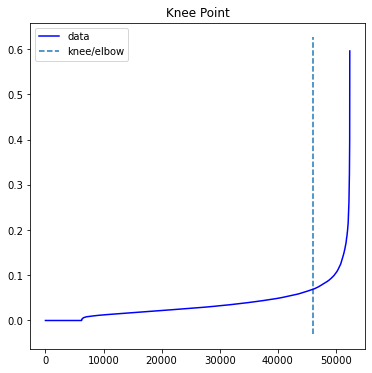

In [69]:
#linkage, elbow, epsilon_best, n_cluster_raw, n_cluster_norm = get_elbow(matrixl2, index, min_clust, sample, kneedle)
epsilon_best = get_elbow2(matrixl2)

In [70]:
epsilon_best

0.06878988444805145

In [63]:
cluster, n_cluster, unclustered = get_cluster(epsilon_best, matrixl2, index, min_clust, 2)

In [64]:
print(n_cluster, unclustered)

786 1079


In [10]:
cluster.to_csv('cluster.csv', index=True, header=True, sep=',', mode='w')
linkage.to_csv('linkage.csv', index=True, header=True, sep=',', mode='w')

In [12]:
pd.DataFrame(matrixl2, index = index).to_csv('matrixl2.csv', index=True, header=True, sep=',', mode='w')